# 模拟退火 Simulated Annealing

xyfJASON

## 1 概述

定义状态 $i$ 的能量为 $E(i)$，在温度 $T$ 下，从状态 $i$ 进入状态 $j$ 遵循如下规律：

- 若 $E(j)\leqslant E(i)$​，则接受该转换；

- 否则，以如下概率接受转换：
  $$
  e^\frac{E(i)-E(j)}{KT}
  $$
  其中，$K$ 在物理意义上是玻尔兹曼常数，但在算法实现中我们取 $K=1$ 即可。

在**特定温度**下，充分次转换后状态的概率分布达到平衡（玻尔兹曼分布）：
$$
P_T(X=i)=\frac{\exp\left(-\frac{E(i)}{KT}\right)}{\sum\limits_{j\in S}\exp\left(-\frac{E(j)}{KT}\right)}
$$
容易知道，当 $T$ 很大时，该分布区倾向于均匀分布，即每种状态等可能出现；而当 $T$ 很小时，该分布倾向于集中在能量最低的状态上，即有很大概率进入能量最小状态。

综上，模拟退火算法步骤如下：

1. 设定初始温度、结束温度、降温比率、能量函数
2. 设定初始状态和状态转换规则，要求当前状态只依赖于前一个状态
3. 在当前温度下按照接受概率进行若干次状态转换
4. 降温
5. 重复 3、4 步骤直至温度低于结束温度

**因此，要用模拟退火算法解决一个实际问题，最关键的步骤是设计好状态表示、能量函数和状态转换规则。**

## 2 代码模板

In [2]:
import numpy as np
import matplotlib.pyplot as plt


class SimulatedAnnealing:
    """
    To run simulated annealing, inherit this class, then
    override 'gen_init_state_energy` and `next_state_energy`.
    """
    def __init__(self,
                 init_T: float,
                 end_T: float,
                 cool_factor: float,
                 steps_per_T: int = 1) -> None:
        self.init_T = init_T
        self.end_T = end_T
        self.cool_factor = cool_factor
        self.steps_per_T = steps_per_T
        self.init_state, self.init_energy = self.gen_init_state_energy()
        self.record_energy = ([], [])  # 0: history; 1: best

    def reset(self) -> None:
        self.init_state, self.init_energy = self.gen_init_state_energy()
        self.record_energy = ([], [])

    def gen_init_state_energy(self) -> tuple[object, float]:
        raise NotImplementedError

    def next_state_energy(self, cur_state: object, cur_energy: float) -> tuple[object, float]:
        raise NotImplementedError

    def step(self, cur_T: float, cur_state: object, cur_energy: float) -> tuple[object, float]:
        next_state, next_energy = self.next_state_energy(cur_state, cur_energy)
        delta_energy = max(0.0, next_energy - cur_energy)
        prob = np.exp(-delta_energy / cur_T)
        if np.random.rand() <= prob:
            return next_state, next_energy
        else:
            return cur_state, cur_energy

    def run(self) -> tuple[object, float]:
        cur_T = self.init_T
        cur_state = self.init_state
        cur_energy = self.init_energy
        best_state = self.init_state
        best_energy = self.init_energy
        while cur_T > self.end_T:
            for _ in range(self.steps_per_T):
                cur_state, cur_energy = self.step(cur_T, cur_state, cur_energy)
                if best_energy > cur_energy:
                    best_state, best_energy = cur_state, cur_energy
                self.record_energy[0].append(cur_energy)
                self.record_energy[1].append(best_energy)
            cur_T *= self.cool_factor
        return best_state, best_energy

    def plot(self, history: bool = True, best: bool = True) -> None:
        assert history or best
        fig, ax = plt.subplots(1, 1)
        length = len(self.record_energy[0])
        if history:
            ax.plot(range(length), self.record_energy[0], label='history', c='dodgerblue')
        if best:
            ax.plot(range(length), self.record_energy[1], label='best', c='darkorange')
        ax.set_title('Energy curve')
        ax.set_xlabel('Iters')
        ax.set_ylabel('Energy')
        plt.legend()
        plt.show()

## 3 例题

### 3.1 例一——旅行商问题（TSP）

http://www.math.uwaterloo.ca/tsp/vlsi/index.html

模拟退火算法解 TSP 问题：

- 状态表示：城市编号序列，依次按照序列顺序访问城市
- 能量函数：路径长度
- 状态转换规则：在当前序列中随机选择一段连续自序列，翻转并插入回原位置

代码如下：

(array([130, 125, 124, 123, 117, 120, 129, 122, 113, 104, 105, 101, 100,
        99, 111,  97,  92,  88,  80,  81,  86,  87,  91,  93,  98, 106,
       112, 107, 108, 114, 126, 127, 128, 121, 116, 119, 115, 118, 109,
       110, 102, 103,  96,  95,  94,  89,  90,  72,  60,  59,  58,  57,
        71,  79,  85,  84,  83,  82,  78,  69,  65,  75,  70,  66,  62,
        56,  51,  50,  55,  61,  64,  68,  77,  76,  74,  67,  63,  73,
        52,  44,  25,  26,  27,  45,  53,  54,  46,  47,  48,  49,  33,
        20,  32,  31,  30,  19,  29,  28,  18,  24,  16,  15,  14,  13,
        17,  12,   4,  11,   5,   0,   6,   7,   1,   2,   8,   9,   3,
        10,  23,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,  21,
        22]), 603.9435948379039)


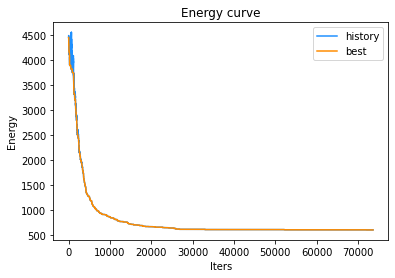

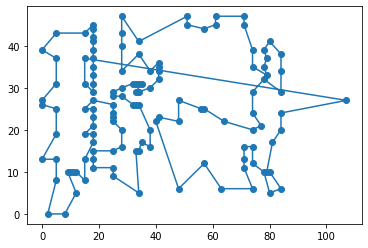

In [4]:
def TSP():
    """
    For this problem, the best result is 564
    refer to https://www.math.uwaterloo.ca/tsp/vlsi/xqf131.tour.html
    """
    with open('tsp_data.txt') as f:
        data = [list(map(int, line.strip().split())) for line in f.readlines()]
        data = np.array(data)
    n = 131

    def distance(_i, _j):
        """ distance between the ith row and the jth row """
        return np.sqrt((data[_i, 1] - data[_j, 1]) ** 2 + (data[_i, 2] - data[_j, 2]) ** 2)

    class Solver(SimulatedAnnealing):
        def gen_init_state_energy(self) -> tuple[np.ndarray, float]:
            best_init_state, best_init_energy = np.arange(n), np.inf
            for _ in range(10):
                init_state = np.random.permutation(n)
                init_energy = 0.0
                for i in range(n):
                    j = (i + 1) % n
                    init_energy += distance(init_state[i], init_state[j])
                if init_energy < best_init_energy:
                    best_init_state, best_init_energy = init_state, init_energy
            return best_init_state, best_init_energy

        def next_state_energy(self, cur_state: np.ndarray, cur_energy: float) -> tuple[np.ndarray, float]:
            u, v = np.random.choice(n+1, 2, replace=False)
            u, v = (v, u) if u > v else (u, v)
            next_state = cur_state.copy()
            next_state[u:v] = next_state[u:v][::-1]  # [u, v)
            next_energy = cur_energy
            if u > 0:
                next_energy -= distance(cur_state[u], cur_state[u-1])
                next_energy += distance(cur_state[v-1], cur_state[u-1])
            if v < n:
                next_energy -= distance(cur_state[v], cur_state[v-1])
                next_energy += distance(cur_state[v], cur_state[u])
            return next_state, next_energy

    solver = Solver(init_T=100,
                    end_T=1e-30,
                    cool_factor=0.999,
                    steps_per_T=1)
    res = solver.run()
    print(res)
    solver.plot()

    def plot_route(res_state):
        fig, ax = plt.subplots(1, 1)
        ax.scatter(data[:, 1], data[:, 2])
        ax.plot(np.hstack((data[res_state, 1], data[res_state[0:1], 1])),
                np.hstack((data[res_state, 2], data[res_state[0:1], 2])))
        plt.show()

    plot_route(res[0])


TSP()

### 3.2 例二

求下列函数在 $[-3,3]^2$ 上的最大值：
$$
F(x,y)=3(1-x)^2e^{-x^2-(y+1)^2}-10\left(\frac{x}{5}-x^3-y^5\right)e^{-x^2-y^2}-\frac{1}{3}^{\exp\left(-(x+1)^2-y^2\right)}
$$
代码如下：

[-0.01394722  1.57744731] 7.150186914480746


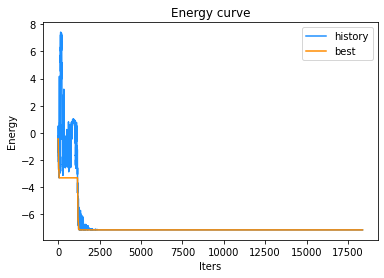

In [5]:
def F(x, y):
    return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3**np.exp(-(x+1)**2-y**2)

class Solver(SimulatedAnnealing):
    def gen_init_state_energy(self) -> tuple[np.ndarray, float]:
        return np.array([0, 0]), -F(0, 0)

    def next_state_energy(self, cur_state: np.ndarray, cur_energy: float) -> tuple[np.ndarray, float]:
        next_state = cur_state + np.random.randn(2) / 10.
        next_state = np.clip(next_state, [-3, -3], [3, 3])
        return next_state, -F(next_state[0], next_state[1])

solver = Solver(init_T=100,
                end_T=1e-30,
                cool_factor=0.996,
                steps_per_T=1)
res = solver.run()
print(res[0], -res[1])
solver.plot()

作图如下：
![](img/sa.png)